In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import joblib
import transformers
import accelerate


In [5]:
mlb = joblib.load("../models/multilabel_binarizer.pkl")
questions_path = "../data/Questions.csv"
tags_path = "../data/Tags.csv"

questions_df = pd.read_csv(questions_path, encoding="ISO-8859-1")
tags_df = pd.read_csv(tags_path, encoding="ISO-8859-1")

tags_grouped = tags_df.groupby("Id")["Tag"].apply(list).reset_index()
merged_df = pd.merge(questions_df, tags_grouped, on="Id")
merged_df = merged_df[["Title", "Body", "Tag"]]
merged_df.columns = ["title", "body", "tags"]



In [9]:
mlb = joblib.load("../models/multilabel_binarizer.pkl")
questions_path = "../data/Questions.csv"
tags_path = "../data/Tags.csv"

questions_df = pd.read_csv(questions_path, encoding="ISO-8859-1")
tags_df = pd.read_csv(tags_path, encoding="ISO-8859-1")

tags_grouped = tags_df.groupby("Id")["Tag"].apply(list).reset_index()
merged_df = pd.merge(questions_df, tags_grouped, on="Id")
merged_df = merged_df[["Title", "Body", "Tag"]]
merged_df.columns = ["title", "body", "tags"]



In [11]:
subset_size = 20000
df_bert = merged_df.iloc[:subset_size].copy()
X_bert = df_bert["title"].astype(str).tolist()
y_bert = mlb.transform(df_bert["tags"])


c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['.emf', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-attributes', '.net-client-profile', '.net-micro-framework', '.nettiers', '16-bit', '2-tier', '256color', '2d', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-studio', '3dcamera', '3dsmax', '64bit', '6502', '7zip', '8051', '960.gs', 'aasm', 'abap', 'ablecommerce', 'abort', 'abpersonviewcontroller', 'absolute-path', 'absolute-value', 'abstract', 'abstract-class', 'abstract-data-type', 'abstract-syntax-tree', 'abstraction', 'abuse', 'accelerator', 'accelerometer', 'accent-insensitive', 'acceptance-testing', 'access-control', 'access-denied', 'access-levels', 'access-modifiers', 'access-specifier', 'access-vba', 'access-violation', 'accessibility', 'accessor', 'accordion', 'account', 'accurev', 'ace-tao', 'ack', 'acl', 'acoustics', 'acpi', 'acrobat', 'action', 'action-filter', 'acti

In [12]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    X_bert, y_bert, test_size=0.2, random_state=42
)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

class BertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(train_encodings, train_labels)
val_dataset = BertDataset(val_encodings, val_labels)


In [11]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=y_bert.shape[1],
    problem_type="multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results_clean",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


Step,Training Loss
500,0.038700
1000,0.034500
1500,0.029700
2000,0.033100
2500,0.028000
3000,0.027000
3500,0.025400
4000,0.026200


TrainOutput(global_step=4000, training_loss=0.030335546016693114, metrics={'train_runtime': 10288.2799, 'train_samples_per_second': 3.11, 'train_steps_per_second': 0.389, 'total_flos': 398096732160000.0, 'train_loss': 0.030335546016693114, 'epoch': 2.0})

In [ ]:
from sklearn.metrics import f1_score


predictions = trainer.predict(val_dataset)
y_pred = predictions.predictions
y_pred = (y_pred > 0.5).astype(int)


print("Micro F1:", f1_score(val_labels, y_pred, average="micro"))
print("Macro F1:", f1_score(val_labels, y_pred, average="macro"))


Micro F1: 0.5155429382540809
Macro F1: 0.282599869143863


c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:

model_path = "../models/distilbert_finetuned"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model and tokenizer saved to {model_path}")

Model and tokenizer saved to ../models/distilbert_finetuned


In [1]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification


model_path = "../models/distilbert_finetuned"


tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)


In [ ]:
from sklearn.metrics import classification_report, f1_score, hamming_loss
import torch
import numpy as np

model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()

batch_size = 32
predictions = []

with torch.no_grad():
    for i in range(0, len(val_texts), batch_size):
        batch_texts = val_texts[i:i+batch_size]
        encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
        outputs = model(**encodings)
        probs = torch.sigmoid(outputs.logits)
        batch_preds = (probs > 0.5).int().numpy()
        predictions.append(batch_preds)


y_pred = np.vstack(predictions)

print("Classification Report:\n")
print(classification_report(val_labels, y_pred, target_names=mlb.classes_))

print("Micro F1 Score:", f1_score(val_labels, y_pred, average='micro'))
print("Macro F1 Score:", f1_score(val_labels, y_pred, average='macro'))
print("Hamming Loss:", hamming_loss(val_labels, y_pred))


Classification Report:

                    precision    recall  f1-score   support

         .htaccess       0.00      0.00      0.00         6
              .net       0.59      0.20      0.29       364
              ajax       0.67      0.56      0.61        39
         algorithm       0.75      0.30      0.43        40
           android       1.00      0.75      0.86        12
         angularjs       0.00      0.00      0.00         0
            apache       0.86      0.27      0.41        22
               api       0.00      0.00      0.00        10
            arrays       0.47      0.32      0.38        22
           asp.net       0.81      0.52      0.63       256
       asp.net-mvc       0.91      0.51      0.66        78
              bash       1.00      0.44      0.61        16
                 c       0.90      0.43      0.58        81
                c#       0.66      0.43      0.52       545
               c++       0.74      0.52      0.61       184
             cl

c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", r

c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", r

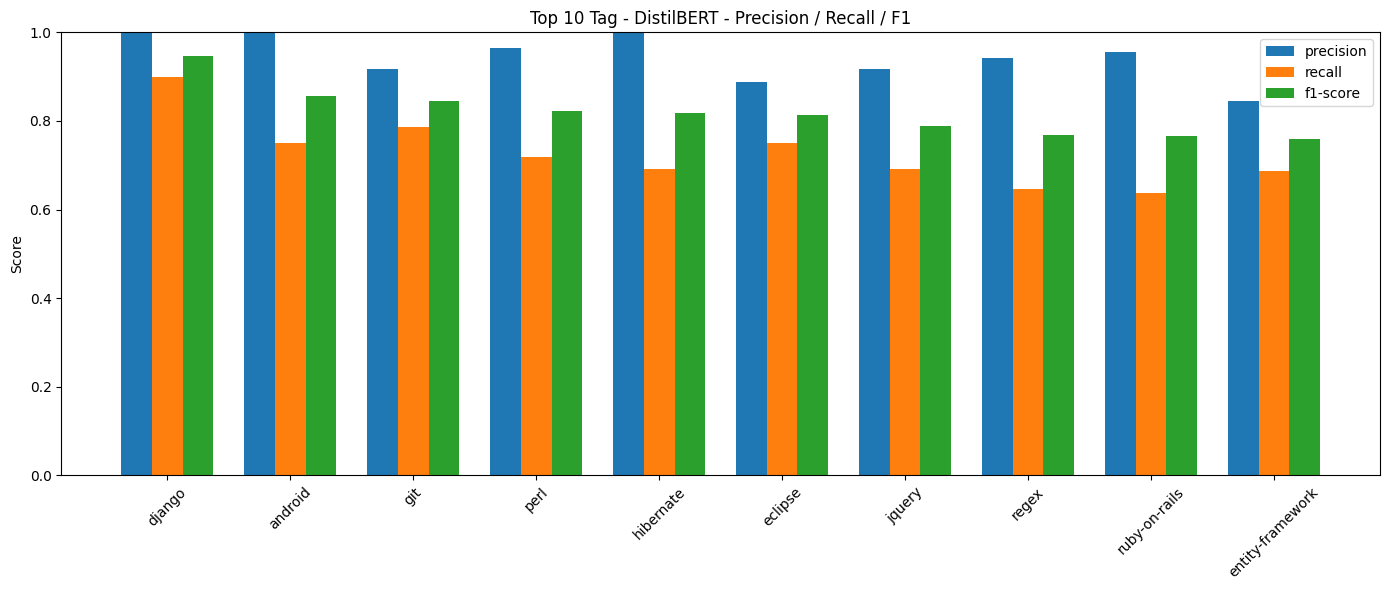

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report


report = classification_report(val_labels, y_pred, target_names=mlb.classes_, output_dict=True)


class_labels = [label for label in report if label not in ('accuracy', 'macro avg', 'micro avg', 'weighted avg')]


top_10 = sorted(class_labels, key=lambda x: report[x]['f1-score'], reverse=True)[:10]


precision = [report[label]['precision'] for label in top_10]
recall = [report[label]['recall'] for label in top_10]
f1 = [report[label]['f1-score'] for label in top_10]

# Grafik çizimi
x = np.arange(len(top_10))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width, precision, width, label='precision')
ax.bar(x, recall, width, label='recall')
ax.bar(x + width, f1, width, label='f1-score')

ax.set_ylabel('Score')
ax.set_title('Top 10 Tag - DistilBERT - Precision / Recall / F1')
ax.set_xticks(x)
ax.set_xticklabels(top_10, rotation=45)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()


c:\Users\Alp\Desktop\Python\stackml-env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


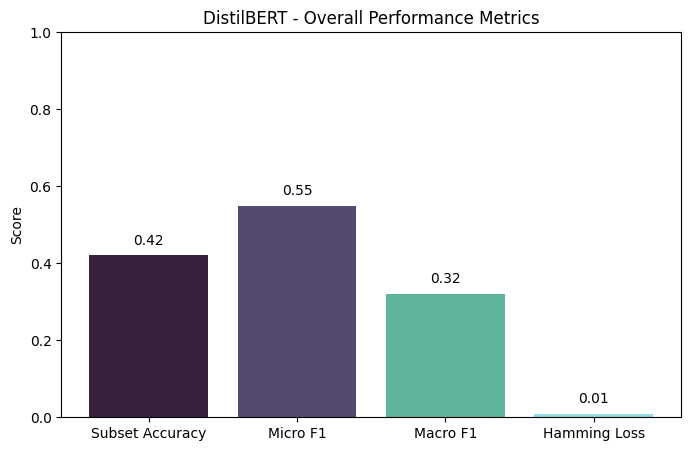

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
import numpy as np


subset_accuracy = np.mean(np.all(val_labels == y_pred, axis=1))


micro_f1 = f1_score(val_labels, y_pred, average='micro')
macro_f1 = f1_score(val_labels, y_pred, average='macro')
hamming = hamming_loss(val_labels, y_pred)


metrics = ['Subset Accuracy', 'Micro F1', 'Macro F1', 'Hamming Loss']
scores = [subset_accuracy, micro_f1, macro_f1, hamming]


plt.figure(figsize=(8,5))
bars = plt.bar(metrics, scores, color=['#36213E', '#554971', '#5FB49C', '#92DCE5'])
plt.ylim(0, 1)
plt.title('DistilBERT - Overall Performance Metrics')
plt.ylabel('Score')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')
plt.show()


In [ ]:
sample_text = ["How can I dynmacially update HTML content using JavaScript and jQuery on a button click?"]
#How to connect a Java application to a MySQL database and perform basic SQL queries?
#Why does my Android app crash when accessing a JSON API from a PHP backend?



encoded = tokenizer(sample_text, truncation=True, padding=True, max_length=512, return_tensors="pt")


model.eval()
with torch.no_grad():
    output = model(**encoded)
    probs = torch.sigmoid(output.logits)
    pred_distilbert = (probs > 0.3 ).int().numpy()


predicted_tags_bert = mlb.inverse_transform(pred_distilbert)[0]

print("DistilBERT Prediction:", predicted_tags_bert)


DistilBERT Prediction: ('html', 'javascript', 'jquery')
